# SEC Data

## First do things that don't need an API Key

Developer page: https://www.sec.gov/developer — max 10 HTTP requests per second before throttle/IP block.

*   RSS feed (latest filings)
*   Daily archive 
*   Quarterly archive (combines dailies at end of each quarter)

Each directory has an `index.html` (default) plus `index.json` and `index.xml` that lists all the files.

### Different file types
*  'form*.idx' — sorted by filing type
*  'company*.idx' — sorted by company name
*  'master*.idx' — sorted by CKID (unique, never-changing SEC identifier for company)
*  Two others—'crawler\*.idx', and 'sitemap\*.xml' I didn't look into



## Setup

In [0]:
import json
import re
import time

import pandas as pd
import requests

from collections import namedtuple
from lxml import etree


### Example RSS

The SEC <a href="https://www.sec.gov/about/secrss.shtml">about RSS</a> page links to an <a href="https://www.sec.gov/cgi-bin/srch-edgar?text=FORM-TYPE%3DS-1%20and%20STATE-OF-INCORPORATION%3DCA&start=1&count=80&first=2012&last=2012&output=atom">example RSS for 2012 S-1 filings in California</a>. Riff on this to try S-1 filings (small business public offerings I think) for all states in 2018...

Upon looking at the contents of these filings, it will be hard to get good information outside of just state quickly. (Some of the filings are done by firms for the entity, and the entity is named deep in the text making it not a good choice for a quick thing like this.)

..so just doing state of incorporation.

#### Count S-1 filings per state (and per capita)
See where the activity mostly is and demonstrate use of the SEC RSS.

##### First get state populations and abbreviations

In [0]:
#------------------------------------------- Census data: State populations --------
# URL path to Excel file (from https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html)
url = 'https://www2.census.gov/programs-surveys/popest/tables/2010-2018/state/totals/nst-est2018-01.xlsx'

# Load the first sheet of the Excel file into a data frame
populations = pd.read_excel(url, header=2, skiprows=1)

# View the first 7 rows
populations.head(7)

# Fix the column names
populations.columns = ["state"] + [str(c) for c in populations.columns[1:]]
populations = populations.dropna()
populations = populations[populations.state.str.startswith(".")].assign(state=populations.state.str.strip('.'))
print(populations.head(5))


#------------------------------------------- BLS data: State abbreviations --------
# There are two tables so get the last one
abbrs = pd.read_html("https://www.bls.gov/cew/cewedr10.htm")[-1]

# The header is in the first row so fix it
abbrs.columns = abbrs.iloc[0]
abbrs = abbrs.reindex(abbrs.index.drop(0))
abbrs = pd.concat([abbrs.iloc[:, 0:2], abbrs.iloc[:, 3:5]]).dropna()
abbrs.columns = ["state", "abbr"]

print(abbrs.head(3))


#------------------------------------------- Map abbreviation to population --------
abbr_to_population = {}
for i, row in abbrs.iterrows():
    try:
        abbr_to_population[row.abbr] = int(populations.loc[populations.state == row.state, "2018"])
    except TypeError:
        # Puerto Rico has a list not a number?
        continue

print(f"Total abbreviations: {len(abbr_to_population)}")
print(", ".join(sorted(abbr_to_population.keys())))
# DC is the extra abbreviation that makes 51

        state      Census  Estimates Base        2010        2011        2012  \
5     Alabama   4779736.0       4780138.0   4785448.0   4798834.0   4815564.0   
6      Alaska    710231.0        710249.0    713906.0    722038.0    730399.0   
7     Arizona   6392017.0       6392288.0   6407774.0   6473497.0   6556629.0   
8    Arkansas   2915918.0       2916028.0   2921978.0   2940407.0   2952109.0   
9  California  37253956.0      37254523.0  37320903.0  37641823.0  37960782.0   

         2013        2014        2015        2016        2017        2018  
5   4830460.0   4842481.0   4853160.0   4864745.0   4875120.0   4887871.0  
6    737045.0    736307.0    737547.0    741504.0    739786.0    737438.0  
7   6634999.0   6733840.0   6833596.0   6945452.0   7048876.0   7171646.0  
8   2959549.0   2967726.0   2978407.0   2990410.0   3002997.0   3013825.0  
9  38280824.0  38625139.0  38953142.0  39209127.0  39399349.0  39557045.0  
     state abbr
1  Alabama   AL
2   Alaska   AK
3  Arizon

##### Next pull the S-1 filing data from the SEC's RSS feed
Loop over the state abbreviations and populate the dataset with total filings per year per state.

First, an example, to understand the format of the response:

In [0]:
base = "https://www.sec.gov/{path}"
search = "cgi-bin/srch-edgar"
query = dict(
    text="FORM-TYPE=S-1 and STATE-OF-INCORPORATION=CA",
    #start=1,
    #count=100,  # Apparently pagination is not necessary so I'm omitting it
    first=2018,
    last=2018,
    output="atom"
)

response = requests.get(base.format(path=search), params=query)

print(f"url: {response.url}\nok? {response.ok}\n")
print(f"Head:\n{response.text[:1500]}")

url: https://www.sec.gov/cgi-bin/srch-edgar?text=FORM-TYPE%3DS-1+and+STATE-OF-INCORPORATION%3DCA&first=2018&last=2018&output=atom
ok? True

Head:
<?xml version="1.0" encoding="ISO-8859-1" ?>
<feed xmlns="http://www.w3.org/2005/Atom">
   <title>Archive of Historical EDGAR Documents</title>
   <link rel="alternate" href="http://www.sec.gov//cgi-bin/srch-edgar?text=FORM-TYPE%3DS-1%20and%20STATE-OF-INCORPORATION%3DCA&amp;start=1&amp;count=80&amp;first=2018&amp;last=2018&amp;output=atom"/>
   <link rel="self" href="http://www.sec.gov//cgi-bin/srch-edgar?text=FORM-TYPE%3DS-1%20and%20STATE-OF-INCORPORATION%3DCA&amp;start=1&amp;count=80&amp;first=2018&amp;last=2018&amp;output=atom"/>
   <id>http://www.sec.gov//cgi-bin/srch-edgar?text=FORM-TYPE%3DS-1%20and%20STATE-OF-INCORPORATION%3DCA&amp;start=1&amp;count=80&amp;first=2018&amp;last=2018&amp;output=atom</id>
   <author><name>Webmaster</name><email>webmaster@sec.gov</email></author>
   <updated>2019-01-02T19:24:40-05:00</updated>
   <entry>
   

To count each entry, we need to
1. pull out the `<feed> ... </feed>` section and convert it to an XML Element Tree
2. count all the entries.

(surprising how few...)

In [0]:
feed = re.search(r"<feed.*feed>", response.text, re.DOTALL).group(0)
root = etree.fromstring(feed)
entries = root.findall("entry", namespaces=root.nsmap)
print(len(entries))


4


Do it for real now

In [0]:
base = "https://www.sec.gov/{path}"
search = "cgi-bin/srch-edgar"


Row = namedtuple("Row", ["year", "state", "population", "s1_count"])

s1_filings_by_state = []
for year in range(2008, 2019):
    for state, population in abbr_to_population.items():
        query = dict(
            text=f"FORM-TYPE=S-1 and STATE-OF-INCORPORATION={state}",
            first=year,
            last=year,
            output="atom"
        )
        response = requests.get(base.format(path=search), params=query)
        feed = re.search(r"<feed.*feed>", response.text, re.DOTALL).group(0)
        root = etree.fromstring(feed)
        entries = root.findall("entry", namespaces=root.nsmap)
        s1_filings_by_state.append(Row(year=year, state=state, population=population, s1_count=len(entries)))
        time.sleep(.5)  # polite throttle?

s1_filings_by_state = pd.DataFrame(s1_filings_by_state)
s1_filings_by_state.head()

,year,state,population,s1_count
0,2008,AL,4887871,55
1,2008,AK,737438,1
2,2008,AZ,7171646,66
3,2008,AR,3013825,14
4,2008,CA,39557045,81


##### Add the per capita value and plot

In [0]:
s1_filings_by_state = s1_filings_by_state.assign(
    s1_per_100k=s1_filings_by_state.s1_count * 1e+5 / s1_filings_by_state.population
)
s1_filings_by_state.loc[s1_filings_by_state.year==2018].sort_values("s1_per_100k", ascending=False).head(12)

,year,state,population,s1_count,s1_per_100k
517,2018,DE,967171,81,8.374941
538,2018,NV,3034392,81,2.669398
560,2018,WY,577737,4,0.692357
515,2018,CO,5695564,15,0.263363
537,2018,NE,1929268,5,0.259166
533,2018,MN,5611179,10,0.178216
542,2018,NY,19542209,22,0.112577
519,2018,FL,21299325,21,0.098595
525,2018,IA,3156145,3,0.095053
554,2018,UT,3161105,3,0.094904


year
2008    2215
2009    2752
2010    2176
2011    1934
2012    2182
2013     527
2014    1805
2015     297
2016     338
2017     363
2018     301
Name: s1_count, dtype: int64


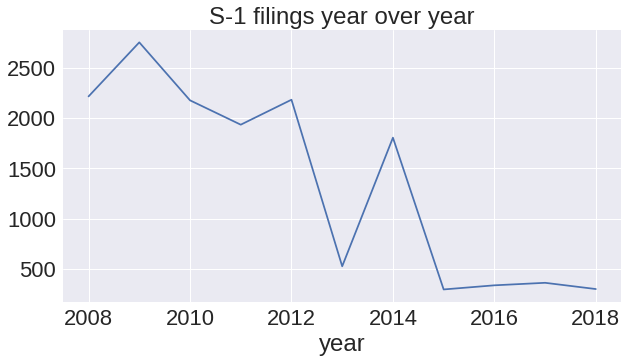

In [0]:
import matplotlib

matplotlib.rc('font', size=24)
matplotlib.rc('axes', labelsize=24) 
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('xtick', labelsize=22)
matplotlib.rc('ytick', labelsize=22) 

all_usa = s1_filings_by_state.groupby("year").s1_count.sum()
print(all_usa)
all_usa.plot(figsize=(10,5), title="S-1 filings year over year");

### Example daily index
What was happening new year's eve?


In [0]:
url = "Archives/edgar/daily-index/2018/QTR4/form.20181231.idx"
response = requests.get(url)
print(response.text[:2000])

Description:           Daily Index of EDGAR Dissemination Feed by Form Type
Last Data Received:    Dec 31, 2018
Comments:              webmaster@sec.gov
Anonymous FTP:         ftp://ftp.sec.gov/edgar/
 
 
 
 
Form Type   Company Name                                                  CIK
      Date Filed  File Name
---------------------------------------------------------------------------------------------------------------------------------------------
1-A/A       American Diversified Energy LLC                               1689500     20181231    edgar/data/1689500/0001683168-18-003825.txt         
1-A/A       UMBRA Technologies (US) Inc.                                  1742808     20181231    edgar/data/1742808/0001742808-18-000004.txt         
1-SA        Nuvus Gro Corp                                                1671132     20181231    edgar/data/1671132/0001079974-18-000687.txt         
1-SA        Red Fish Properties, Inc.                                     1703429     2018

The URLs are where the information is. We need to parse this fixed-width file to get the data.

In [0]:
beginning = re.search("^Form Type", response.text, re.MULTILINE).span()[0]
header, body = re.split("-+\n", response.text[beginning:], re.MULTILINE)

# Find the start of each column
starts = [0] + [match.span()[-1] for match in re.finditer("\s{2,}", header)]

def parse(line):
    return [line[i:j].strip() for i, j in zip(starts, starts[1:] + [-1])]


field_names = [s.replace(" ", "_").lower() for s in parse(header)]
Row = namedtuple("Row", field_names)

print("field names are: ", ", ".join(field_names))

field names are:  form_type, company_name, cik, date_filed, file_name


In [0]:
rows = [Row(*parse(line)) for line in body.splitlines()]
print(f"{len(rows)} rows.\nFirst row:\n\n{rows[0]}")

2619 rows.
First row:

Row(form_type='1-A/A', company_name='American Diversified Energy LLC', cik='1689500', date_filed='20181231', file_name='edgar/data/1689500/0001683168-18-003825.txt')


##### Something quick -- how about a count of form types?
On New Year's eve...

In [0]:
from collections import Counter

form_types = Counter(row.form_type for row in rows)
print(f"{len(form_types)} different forms")
form_types.most_common(10)

77 different forms


[('4', 769),
 ('424B2', 416),
 ('497K', 358),
 ('D', 127),
 ('8-K', 118),
 ('FWP', 114),
 ('497', 76),
 ('10-D', 61),
 ('6-K', 54),
 ('D/A', 52)]

In [0]:
Counter(row.company_name for row in rows).most_common(5)

[('CREDIT SUISSE AG', 121),
 ('EQ ADVISORS TRUST', 99),
 ('JPMORGAN CHASE & CO', 85),
 ('JPMorgan Chase Financial Co. LLC', 85),
 ('HYSTER-YALE MATERIALS HANDLING, INC.', 64)]

##### Woww, JP Morgan Chase filed 85 + 85 = 170 forms on New Year's eve?

What are they??

In [0]:
jpmorgans_newyears = pd.DataFrame([row for row in rows if row.company_name.lower().startswith("jpmor")])
print(jpmorgans_newyears.form_type.unique())

jpmorgans_newyears.head()

['424B2' 'FWP']


,form_type,company_name,cik,date_filed,file_name
0,424B2,JPMORGAN CHASE & CO,19617,20181231,edgar/data/19617/0000891092-18-009427.txt
1,424B2,JPMORGAN CHASE & CO,19617,20181231,edgar/data/19617/0000891092-18-009428.txt
2,424B2,JPMORGAN CHASE & CO,19617,20181231,edgar/data/19617/0000891092-18-009431.txt
3,424B2,JPMORGAN CHASE & CO,19617,20181231,edgar/data/19617/0000891092-18-009445.txt
4,424B2,JPMORGAN CHASE & CO,19617,20181231,edgar/data/19617/0000891092-18-009446.txt


Let's see one of each form.

In [0]:
 jpmorgans_newyears[jpmorgans_newyears.form_type == '424B2'].file_name.iloc[0]

'edgar/data/19617/0000891092-18-009427.txt'

In [0]:
url_suffix =  jpmorgans_newyears[jpmorgans_newyears.form_type == '424B2'].file_name.iloc[0]
a_424b2_form = requests.get("https://www.sec.gov/Archives/" + url_suffix).text

url_suffix =  jpmorgans_newyears[jpmorgans_newyears.form_type == 'FWP'].file_name.iloc[0]
an_fwp_form = requests.get("https://www.sec.gov/Archives/" + url_suffix).text


print("*" * 42)
print("Form 424B2")
print(a_424b2_form[:2000])

print()
print("*" * 42)
print("Form FWP")
print(an_fwp_form[:2000])

******************************************
Form 424B2
<SEC-DOCUMENT>0000891092-18-009427.txt : 20181231
<SEC-HEADER>0000891092-18-009427.hdr.sgml : 20181231
<ACCEPTANCE-DATETIME>20181228175504
ACCESSION NUMBER:		0000891092-18-009427
CONFORMED SUBMISSION TYPE:	424B2
PUBLIC DOCUMENT COUNT:		4
FILED AS OF DATE:		20181231
DATE AS OF CHANGE:		20181228

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			JPMORGAN CHASE & CO
		CENTRAL INDEX KEY:			0000019617
		STANDARD INDUSTRIAL CLASSIFICATION:	NATIONAL COMMERCIAL BANKS [6021]
		IRS NUMBER:				132624428
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		424B2
		SEC ACT:		1933 Act
		SEC FILE NUMBER:	333-222672
		FILM NUMBER:		181258224

	BUSINESS ADDRESS:	
		STREET 1:		270 PARK AVE
		STREET 2:		38TH FL
		CITY:			NEW YORK
		STATE:			NY
		ZIP:			10017
		BUSINESS PHONE:		2122706000

	MAIL ADDRESS:	
		STREET 1:		270 PARK AVENUE
		CITY:			NEW YORK
		STATE:			NY
		ZIP:			10017

	FORMER COMPANY:	
		FORMER CONFORM

### Example quarterly archive


Why not Sears? They're from Chicago.
1. get CKID (https://www.sec.gov/edgar/searchedgar/companysearch.html)
    * search for 'Sears Holdings Corp'
    * CKID = 0001310067
2. Go back to the archives and find that ID and the forms you care about


In [0]:
url = "https://www.sec.gov/Archives/edgar/full-index/2018/QTR4/master.idx"
response = requests.get(url)
print(response.text[:2000])

Description:           Master Index of EDGAR Dissemination Feed
Last Data Received:    December 31, 2018
Comments:              webmaster@sec.gov
Anonymous FTP:         ftp://ftp.sec.gov/edgar/
Cloud HTTP:            https://www.sec.gov/Archives/

 
 
 
CIK|Company Name|Form Type|Date Filed|Filename
--------------------------------------------------------------------------------
1000045|NICHOLAS FINANCIAL INC|10-Q|2018-11-14|edgar/data/1000045/0001193125-18-326090.txt
1000045|NICHOLAS FINANCIAL INC|4|2018-10-15|edgar/data/1000045/0001357521-18-000008.txt
1000045|NICHOLAS FINANCIAL INC|4|2018-11-15|edgar/data/1000045/0001357521-18-000009.txt
1000045|NICHOLAS FINANCIAL INC|4|2018-12-14|edgar/data/1000045/0001357521-18-000010.txt
1000045|NICHOLAS FINANCIAL INC|8-K|2018-11-01|edgar/data/1000045/0001193125-18-314942.txt
1000045|NICHOLAS FINANCIAL INC|8-K|2018-11-06|edgar/data/1000045/0001193125-18-319610.txt
1000045|NICHOLAS FINANCIAL INC|8-K|2018-12-06|edgar/data/1000045/0001193125-18-3430

#### Cool! It lookd like the 'master' form is pipe-separated, which sucks less.

In [0]:
data = response.text.rsplit("\n\n", 1)[-1].strip()
header = data.split("\n", 1)[0].split("|")
field_names = [field.replace(" ", "_").lower() for field in header]
MasterRow = namedtuple("MasterRow", field_names)

rows = [MasterRow(*line.split("|")) for line in data.splitlines()[2:]]
print(f"Total documents filed in Q4 last year: {len(rows)}")


sears_cik = "0001310067".lstrip("0")
#tesla_cik = "0001318605".lstrip("0")
keep_rows = [row for row in rows if row.cik == sears_cik]
print(f"Total documents filed by Sears Holdings in Q4 last year: {len(keep_rows)}")

sears_2018q4_filings = pd.DataFrame(keep_rows)
print(f"unique forms filed: {sears_2018q4_filings.form_type.unique()}")
sears_2018q4_filings.head()

Total documents filed in Q4 last year: 197032
Total documents filed by Sears Holdings in Q4 last year: 24
unique forms filed: ['10-Q' '25-NSE' '3' '4' '8-K/A' '8-K' 'CORRESP' 'CT ORDER' 'SC 13D/A'
 'SC 13G/A' 'UPLOAD']


,cik,company_name,form_type,date_filed,filename
0,1310067,SEARS HOLDINGS CORP,10-Q,2018-12-13,edgar/data/1310067/0001310067-18-000029.txt
1,1310067,SEARS HOLDINGS CORP,25-NSE,2018-11-15,edgar/data/1310067/0001354457-18-000476.txt
2,1310067,SEARS HOLDINGS CORP,3,2018-10-15,edgar/data/1310067/0000899243-18-026670.txt
3,1310067,SEARS HOLDINGS CORP,3,2018-10-17,edgar/data/1310067/0000899243-18-026853.txt
4,1310067,SEARS HOLDINGS CORP,3,2018-10-19,edgar/data/1310067/0000899243-18-027048.txt


#### How many Schedule 13s?

In [0]:
sears_2018q4_filings[sears_2018q4_filings.form_type.str.startswith("SC 13")]

,cik,company_name,form_type,date_filed,filename
19,1310067,SEARS HOLDINGS CORP,SC 13D/A,2018-10-17,edgar/data/1310067/0001193125-18-300694.txt
20,1310067,SEARS HOLDINGS CORP,SC 13D/A,2018-11-16,edgar/data/1310067/0001193125-18-328517.txt
21,1310067,SEARS HOLDINGS CORP,SC 13D/A,2018-12-06,edgar/data/1310067/0001193125-18-343049.txt
22,1310067,SEARS HOLDINGS CORP,SC 13G/A,2018-10-19,edgar/data/1310067/0000919574-18-006748.txt


Let's see the December one then we're done

In [0]:
form_mask = sears_2018q4_filings.form_type == 'SC 13D/A'
date_mask = sears_2018q4_filings.date_filed == '2018-12-06'

url_suffix =  sears_2018q4_filings[form_mask & date_mask].filename.iloc[0]
dec_sc13d_form = requests.get("https://www.sec.gov/Archives/" + url_suffix).text


print("Form SC 14D/A")
print(dec_sc13d_form[:2000])

Form SC 14D/A
<SEC-DOCUMENT>0001193125-18-343049.txt : 20181206
<SEC-HEADER>0001193125-18-343049.hdr.sgml : 20181206
<ACCEPTANCE-DATETIME>20181206084402
ACCESSION NUMBER:		0001193125-18-343049
CONFORMED SUBMISSION TYPE:	SC 13D/A
PUBLIC DOCUMENT COUNT:		2
FILED AS OF DATE:		20181206
DATE AS OF CHANGE:		20181206
GROUP MEMBERS:		EDWARD S. LAMPERT
GROUP MEMBERS:		ESL INVESTMENTS, INC.
GROUP MEMBERS:		JPP II, LLC
GROUP MEMBERS:		JPP, LLC
GROUP MEMBERS:		RBS PARTNERS, L.P.
GROUP MEMBERS:		SPE I PARTNERS, LP
GROUP MEMBERS:		SPE MASTER I, LP

SUBJECT COMPANY:	

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			SEARS HOLDINGS CORP
		CENTRAL INDEX KEY:			0001310067
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-DEPARTMENT STORES [5311]
		IRS NUMBER:				201920798
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			0203

	FILING VALUES:
		FORM TYPE:		SC 13D/A
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	005-80635
		FILM NUMBER:		181219069

	BUSINESS ADDRESS:	
		STREET 1:		3333 BEVERLY ROAD
		CITY:			HOFFMAN ES

## Next do things that require an API key

Developer page: http://developer.edgar-online.com/docs/v1
*  max 2 HTTP requests per second
*  max 5000 requests per day (if unpaid)
*  5 years of data (if unpaid) seems like sometimes less
* free stuff i listed in <a href="https://developer.edgar-online.com/docs/v1#nav12">this table</a>


In [0]:
import getpass
print("Go to http://developer.edgar-online.com/member/my-account for your API key.")
apikey = getpass.getpass(prompt="edgar-online api key: ")

Go to http://developer.edgar-online.com/member/my-account for your API key.
edgar-online api key: ··········


### Free stuff 0
company names

In [0]:
base_url = "http://datafied.api.edgar-online.com/v1/"
companies_api = base_url + "companies"
# Chicago !
query = dict(
    cities="chicago",
    sortby="entityid",
    appkey=f"{apikey}",
)
response = requests.get(companies_api, params=query)
data = response.json()

print(json.dumps(data, indent=2)[:1000])

{
  "result": {
    "limit": 25,
    "offset": 0,
    "totalrows": 203,
    "rowset": [
      {
        "entityid": 91,
        "cik": "0000074046",
        "companyname": "OIL-DRI CORP OF AMERICA",
        "primaryexchange": "NYSE",
        "primarysymbol": "ODC",
        "siccode": "3990",
        "sicdescription": "Miscellaneous Manufacturing Industries",
        "rownum": 1
      },
      {
        "entityid": 197,
        "cik": "0000047518",
        "companyname": "HILL-ROM HOLDINGS, INC.",
        "primaryexchange": "NYSE",
        "primarysymbol": "HRC",
        "siccode": "3841",
        "sicdescription": "Surgical and Medical Instruments and Apparatus",
        "rownum": 2
      },
      {
        "entityid": 311,
        "cik": "0000770944",
        "companyname": "BALLY TOTAL FITNESS HOLDING CORP",
        "siccode": "7997",
        "sicdescription": "Services-Membership Sports and Recreation Clubs",
        "rownum": 3
      },
      {
        "entityid": 396,
        "cik

Rad! So what Chicago-based companies are publicly traded?

In [0]:
pd.DataFrame(data["result"]["rowset"]).sort_values(["primaryexchange", "primarysymbol"])

,cik,companyname,entityid,primaryexchange,primarysymbol,rownum,siccode,sicdescription
16,0000730464,ADTALEM GLOBAL EDUCATION INC.,3054,NYSE,ATGE,17,8200,Services-Educational Services
8,0000921825,FIRST INDUSTRIAL REALTY TRUST INC,2009,NYSE,FR,9,6798,Real Estate Investment Trusts
1,0000047518,"HILL-ROM HOLDINGS, INC.",197,NYSE,HRC,2,3841,Surgical and Medical Instruments and Apparatus
9,0000063908,MCDONALDS CORP,2163,NYSE,MCD,10,5812,Retail-Eating Places
13,0000068505,"MOTOROLA SOLUTIONS, INC.",2749,NYSE,MSI,14,3663,Radio and Television Broadcasting and Communic...
0,0000074046,OIL-DRI CORP OF AMERICA,91,NYSE,ODC,1,3990,Miscellaneous Manufacturing Industries
21,0000074260,OLD REPUBLIC INTERNATIONAL CORP,3358,NYSE,ORI,22,6351,Surety Insurance
15,0000726513,TRIBUNE MEDIA CO,2871,NYSE,TRCO,16,4833,Television Broadcasting Stations
14,0000821130,UNITED STATES CELLULAR CORP,2839,NYSE,USM,15,4812,Radiotelephone Communications
5,0000740260,VENTAS INC,1093,NYSE,VTR,6,6798,Real Estate Investment Trusts


### That is rad
But I want Sears specifically (I guess their bankruptcy makes me sad). I also guess "Chicago" means actual Chicago not Hoffman Estates so here's them:

In [0]:
base_url = "http://datafied.api.edgar-online.com/v1/"
companies_api = base_url + "companies"
query = dict(
    companynames="*sears*",
    sortby="entityid",
    appkey=f"{apikey}",
)
response = requests.get(companies_api, params=query)

In [0]:
print(json.dumps(response.json(), indent=2)[:2000])

{
  "result": {
    "limit": 25,
    "offset": 0,
    "totalrows": 6,
    "rowset": [
      {
        "entityid": 7311,
        "cik": "0000319256",
        "companyname": "SEARS ROEBUCK & CO",
        "siccode": "5311",
        "sicdescription": "Retail-Department Stores",
        "rownum": 1
      },
      {
        "entityid": 656789,
        "cik": "0001310067",
        "companyname": "SEARS HOLDINGS CORP",
        "primaryexchange": "OTC",
        "primarysymbol": "SHLDQ",
        "siccode": "5311",
        "sicdescription": "Retail-Department Stores",
        "rownum": 2
      },
      {
        "entityid": 779720,
        "cik": "0001434737",
        "companyname": "SEARS OIL & GAS",
        "primaryexchange": "OTC",
        "primarysymbol": "SRSG",
        "siccode": "1311",
        "sicdescription": "Crude Petroleum and Natural Gas",
        "rownum": 3
      },
      {
        "entityid": 813715,
        "cik": "0001472862",
        "companyname": "WILLIAMSVILLE SEARS MANAGEM

### Free stuff I
Where to get the string that represents the terms: <a href="https://developer.edgar-online.com/docs/v1#nav6">this table</a>

*  Balance Sheet - Consolidated	`BalanceSheetConsolidated`
*  Income Statement - Consolidated	`IncomeStatementConsolidated`
*  Cash Flow Statement - Consolidated	`CashFlowStatementConsolidated`

In [0]:
base_url = "http://datafied.api.edgar-online.com/v1/"
financials_api = base_url + "corefinancials"

query = dict(
    primarysymbols="SHLDQ",
    #fields="primarysymbol",
    conceptgroups="BalanceSheetConsolidated,IncomeStatementConsolidated,CashFlowStatementConsolidated",
    appkey=apikey
)

response = requests.get(financials_api, params=query)
print(json.dumps(response.json(), indent=2)[:2000])

{
  "result": {
    "limit": 25,
    "offset": 0,
    "totalrows": 4,
    "duration": "ANN",
    "rowset": [
      {
        "rownum": 1,
        "entityid": 656789,
        "groups": [
          {
            "conceptgroups": [
              "IncomeStatementConsolidated",
              "IncomeStatementFull",
              "PrimaryFinancials"
            ],
            "fiscalyear": 2018,
            "fiscalquarter": 4,
            "rowset": [
              {
                "precision": 0,
                "type": "decimal",
                "field": "EBIT",
                "value": -2078000000.0,
                "label": "EBIT"
              },
              {
                "precision": 0,
                "type": "decimal",
                "field": "CostofRevenue",
                "value": 13175000000.0,
                "label": "Cost of Revenue"
              },
              {
                "precision": 0,
                "type": "decimal",
                "field": "DepreciationA

In [0]:
dataset = response.json()
print(dataset["result"].keys())

dict_keys(['limit', 'offset', 'totalrows', 'duration', 'rowset'])


In [0]:
for i, rowset in enumerate(dataset["result"]["rowset"]):
    print("*" * 10 + f" rowset {i}")
    for group in rowset['groups']:
        print(", ".join(f"{k}: {group[k]}" for k in ('conceptgroups', 'fiscalyear', 'fiscalquarter',)))

********** rowset 0
conceptgroups: ['IncomeStatementConsolidated', 'IncomeStatementFull', 'PrimaryFinancials'], fiscalyear: 2018, fiscalquarter: 4
conceptgroups: ['CashFlowStatementConsolidated', 'CashFlowStatementFull', 'PrimaryFinancials'], fiscalyear: 2018, fiscalquarter: 4
conceptgroups: ['BalanceSheetConsolidated', 'BalanceSheetFull', 'PrimaryFinancials'], fiscalyear: 2018, fiscalquarter: 4
conceptgroups: ['Metadata', 'MetadataFree'], fiscalyear: 2018, fiscalquarter: 4
conceptgroups: ['FinancialHeaderData', 'PrimaryFinancials'], fiscalyear: 2018, fiscalquarter: 4
********** rowset 1
conceptgroups: ['IncomeStatementConsolidated', 'IncomeStatementFull', 'PrimaryFinancials'], fiscalyear: 2017, fiscalquarter: 4
conceptgroups: ['CashFlowStatementConsolidated', 'CashFlowStatementFull', 'PrimaryFinancials'], fiscalyear: 2017, fiscalquarter: 4
conceptgroups: ['BalanceSheetConsolidated', 'BalanceSheetFull', 'PrimaryFinancials'], fiscalyear: 2017, fiscalquarter: 4
conceptgroups: ['Metadata'

#### One more key... "rowset"
print the last group's keys and then the first couple terms in the rowset

In [0]:
print(group.keys())
print(group["conceptgroups"])
print(group["rowset"][:3])

dict_keys(['conceptgroups', 'fiscalyear', 'fiscalquarter', 'rowset'])
['FinancialHeaderData', 'PrimaryFinancials']
[{'type': 'date', 'field': 'PeriodEndDate', 'value': '1/31/2015', 'label': 'Period End Date'}, {'type': 'integer', 'field': 'fiscalYear', 'value': 2015, 'label': 'Fiscal Year'}, {'type': 'integer', 'field': 'FiscalQuarter', 'value': 4, 'label': 'Fiscal Quarter'}]


#### Looks like the fields are the same. Try Pandas to read it.

In [0]:
pd.DataFrame(group["rowset"])

,field,label,type,value
0,PeriodEndDate,Period End Date,date,1/31/2015
1,fiscalYear,Fiscal Year,integer,2015
2,FiscalQuarter,Fiscal Quarter,integer,4


#### Wow. So granular
OK group all the response stuff together.
*  The different response groups are:
  - ['IncomeStatementConsolidated', 'IncomeStatementFull', 'PrimaryFinancials']
  - ['CashFlowStatementConsolidated', 'CashFlowStatementFull', 'PrimaryFinancials']
  - ['BalanceSheetConsolidated', 'BalanceSheetFull', 'PrimaryFinancials']
  - ['Metadata', 'MetadataFree']
  - ['FinancialHeaderData', 'PrimaryFinancials']
* The only reason there are so many is because I asked for them all in the query


Do them separately to reduce the complication. The header stuff came along for the ride. Maybe I can omit that...but first see what it is:

In [0]:
def has_term(conceptgroup, term):
    return any(term.lower() in c.lower() for c in conceptgroup)

metadata = pd.concat(
    pd.DataFrame(groups["rowset"])
    for rowset in dataset["result"]["rowset"]
    for groups in rowset["groups"] if has_term(groups["conceptgroups"], "meta")
)
headers = pd.concat(
    pd.DataFrame(groups["rowset"])
    for rowset in dataset["result"]["rowset"]
    for groups in rowset["groups"] if has_term(groups["conceptgroups"], "header")
)

print("{0} {1} {0}".format("*" * 20, "metadata"))
print(metadata)

print("\n{0} {1} {0}".format("*" * 20, "headers"))
print(headers)

******************** metadata ********************
      field     label    type value
0  duration  Duration  string   ANN
0  duration  Duration  string   ANN
0  duration  Duration  string   ANN
0  duration  Duration  string   ANN

******************** headers ********************
           field            label     type      value
0  PeriodEndDate  Period End Date     date   2/3/2018
1     fiscalYear      Fiscal Year  integer       2018
2  FiscalQuarter   Fiscal Quarter  integer          4
0  PeriodEndDate  Period End Date     date  1/28/2017
1     fiscalYear      Fiscal Year  integer       2017
2  FiscalQuarter   Fiscal Quarter  integer          4
0  PeriodEndDate  Period End Date     date  1/30/2016
1     fiscalYear      Fiscal Year  integer       2016
2  FiscalQuarter   Fiscal Quarter  integer          4
0  PeriodEndDate  Period End Date     date  1/31/2015
1     fiscalYear      Fiscal Year  integer       2015
2  FiscalQuarter   Fiscal Quarter  integer          4


#### The headers are not useful
* We know the data are annual because that's all the free API gives us; no information here.
* The year (I believe) is included in the other datasets.
* However I tried to remove them and can't seem to so still use the `has_term` function to filter for
    - balance sheet
    - cash flow statement
    - income statement

##### Balance sheet only

In [0]:
base_url = "http://datafied.api.edgar-online.com/v1/"
financials_api = base_url + "corefinancials"

query = dict(
    primarysymbols="SHLDQ",
    conceptgroups="BalanceSheetConsolidated",
    appkey=apikey
)

response = requests.get(financials_api, params=query)
dataset = response.json()

balance_sheet = pd.concat(
    pd.DataFrame(groups["rowset"])
    for rowset in dataset["result"]["rowset"]
    for groups in rowset["groups"] if has_term(groups["conceptgroups"], "balance")
)

print(f"Shape of data frame: {balance_sheet.shape}; non-null: {balance_sheet.dropna().shape}")
balance_sheet.dropna().head()

Shape of data frame: (168, 5); non-null: (116, 5)


,field,label,precision,type,value
1,CommonStock,Common Stock,0,decimal,1.000000e+06
5,AccountsPayableandAccruedExpenses,Accounts Payable and Accrued Expenses,0,decimal,2.470000e+08
7,AdditionalPaidinCapital,Additional Paid-in Capital,0,decimal,9.063000e+09
9,CashandCashEquivalents,Cash and Cash Equivalents,0,decimal,1.820000e+08
10,CashCashEquivalentsandShorttermInvestments,"Cash, Cash Equivalents and Short-term Investments",0,decimal,3.360000e+08


##### Income statement only

In [0]:
base_url = "http://datafied.api.edgar-online.com/v1/"
financials_api = base_url + "corefinancials"

query = dict(
    primarysymbols="SHLDQ",
    conceptgroups="IncomeStatementConsolidated",
    appkey=apikey
)

response = requests.get(financials_api, params=query)
dataset = response.json()

income_statement = pd.concat(
    pd.DataFrame(groups["rowset"])
    for rowset in dataset["result"]["rowset"]
    for groups in rowset["groups"] if has_term(groups["conceptgroups"], "income")
)

print(f"Shape of data frame: {income_statement.shape}; non-null: {income_statement.dropna().shape}")
income_statement.dropna().head()

Shape of data frame: (100, 5); non-null: (72, 5)


,field,label,precision,type,value
0,EBIT,EBIT,0,decimal,-2.078000e+09
1,CostofRevenue,Cost of Revenue,0,decimal,1.317500e+10
2,DepreciationAmortizationExpense,Depreciation & Amortization Expense,0,decimal,3.320000e+08
3,DilutedEPSNetIncome,"Diluted EPS, Net Income",0,decimal,-3.570000e+00
7,BasicEPSNetIncome,"Basic EPS, Net Income",0,decimal,-3.570000e+00


##### Cash flow statement only

In [0]:
base_url = "http://datafied.api.edgar-online.com/v1/"
financials_api = base_url + "corefinancials"

query = dict(
    primarysymbols="SHLDQ",
    conceptgroups="CashFlowStatementConsolidated",
    appkey=apikey
)

response = requests.get(financials_api, params=query)
dataset = response.json()

cash_flow = pd.concat(
    pd.DataFrame(groups["rowset"])
    for rowset in dataset["result"]["rowset"]
    for groups in rowset["groups"] if has_term(groups["conceptgroups"], "cash")
)

print(f"Shape of data frame: {cash_flow.shape}; non-null: {cash_flow.dropna().shape}")
cash_flow.dropna().head()

Shape of data frame: (156, 5); non-null: (108, 5)


,field,label,precision,type,value
0,ChangeinCurrentAssets,Change in Current Assets,0,decimal,1.922000e+09
1,ChangeinCurrentLiabilities,Change in Current Liabilities,0,decimal,-4.720000e+08
2,ChangeinDebtNet,"Change in Debt, Net",0,decimal,4.100000e+07
6,ChangeinInventories,Change in Inventories,0,decimal,1.144000e+09
7,ChangeinOperatingAssetsLiabilities,Change in Operating Assets & Liabilities,0,decimal,9.160000e+08


#### Conclusion

If you want to see annual Balance sheet / Cash flow statement/ Income statement then the above workflow looks good:

company API request --> primary symbol (e.g. SHLDQ)
core financials API request --> Filter for desired concept group --> Pandas
And then honestly to Excel would be my workflow...and students can analyze the data

In [0]:
cash_flow.to_excel("sears_cash_flow.xls", index=False)


from google.colab import files
files.download('sears_cash_flow.xls')

#### Free stuff II
*  Valuation Ratios - Mini	`ValuationRatiosMini`
*  Profitability Ratios - Mini	`ProfitabilityRatiosMini`
*  Leverage Ratios - Mini	`LeverageRatiosMini`
*  Liquidity Ratios - Mini	`LiquidityRatiosMini`
* Financial Ratio `FinancialRatioData`

In [0]:
base_url = "http://datafied.api.edgar-online.com/v1/"
financials_api = base_url + "corefinancials"

query = dict(
    primarysymbols="SHLDQ",
    conceptgroups="ValuationRatiosMini",
    appkey=apikey
)

response = requests.get(financials_api, params=query)
dataset = response.json()

print(json.dumps(dataset, indent=2)[:1000])

{
  "result": {
    "limit": 25,
    "offset": 0,
    "totalrows": 4,
    "duration": "ANN",
    "rowset": [
      {
        "rownum": 1,
        "entityid": 656789,
        "groups": [
          {
            "conceptgroups": [
              "Ratios",
              "ValuationRatios",
              "ValuationRatiosMini"
            ],
            "fiscalyear": 2018,
            "fiscalquarter": 4,
            "rowset": [
              {
                "precision": 0,
                "type": "decimal",
                "field": "MarketCapBasic",
                "value": 53519000.0,
                "label": "Market Cap - Basic"
              },
              {
                "precision": 0,
                "type": "decimal",
                "field": "MarketCapDiluted",
                "value": 53519000.0,
                "label": "Market Cap - Diluted"
              },
              {
                "precision": 0,
                "type": "decimal",
                "field": "MarketCapT

#### Looks like the format is the same as above, woo!

In [0]:
valuation_ratios = pd.concat(
    pd.DataFrame(groups["rowset"])
    for rowset in dataset["result"]["rowset"]
    for groups in rowset["groups"] if has_term(groups["conceptgroups"], "valuation")
)

print(f"Shape of data frame: {valuation_ratios.shape}; non-null: {valuation_ratios.dropna().shape}")
valuation_ratios.dropna().head()

Shape of data frame: (28, 5); non-null: (28, 5)


,field,label,precision,type,value
0,MarketCapBasic,Market Cap - Basic,0,decimal,5.351900e+07
1,MarketCapDiluted,Market Cap - Diluted,0,decimal,5.351900e+07
2,MarketCapTSO,Market Cap - TSO,0,decimal,5.363492e+07
3,PriceBookFQ,"Price/Book, FQ",0,decimal,-1.010000e-02
4,PriceBookFY,"Price/Book, FY",0,decimal,-6.780000e-02


#### All the rest

In [0]:
base_url = "http://datafied.api.edgar-online.com/v1/"
financials_api = base_url + "corefinancials"

query = dict(
    primarysymbols="SHLDQ",
    conceptgroups="ValuationRatiosMini",
    appkey=apikey
)

dataframes = []
fields = ['ProfitabilityRatiosMini', 'LeverageRatiosMini', 'LiquidityRatiosMini','FinancialRatioData']
for field in fields:
    query['conceptgroups'] = field
    response = requests.get(financials_api, params=query)
    dataset = response.json()
    df = pd.concat(
        pd.DataFrame(groups["rowset"])
        for rowset in dataset["result"]["rowset"]
        for groups in rowset["groups"] if has_term(groups["conceptgroups"], field)
    )
    dataframes.append(df)
    print(f"Field: {field} -- Shape of non-null: {df.dropna().shape}")
    print(df.head())
    print()

Field: ProfitabilityRatiosMini -- Shape of non-null: (24, 5)
                  field                   label  precision     type   value
0      GrossMarginPctFQ      Gross Margin %, FQ          0  decimal  0.1971
1      GrossMarginPctFY      Gross Margin %, FY          0  decimal  0.2112
2     GrossMarginPctTTM     Gross Margin %, TTM          0  decimal  0.1971
3  OperatingMarginPctFQ  Operating Margin %, FQ          0  decimal -0.1767
4  OperatingMarginPctFY  Operating Margin %, FY          0  decimal -0.1244

Field: LeverageRatiosMini -- Shape of non-null: (12, 5)
            field               label  precision     type    value
0    DebttoEquity      Debt to Equity          0  decimal -1.33092
1  DebttoEquityFQ  Debt to Equity, FQ          0  decimal -0.72750
2  DebttoEquityFY  Debt to Equity, FY          0  decimal -1.33090
0    DebttoEquity      Debt to Equity          0  decimal -1.42416
1  DebttoEquityFQ  Debt to Equity, FQ          0  decimal -0.72750

Field: LiquidityRatiosM

## Conclusion
The SEC APIs are worth a look:
* The forms API is free.
    - Documentation: https://www.sec.gov/edgar/searchedgar/accessing-edgar-data.htm
    - API: https://www.sec.gov/Archives/
    - Index files can be fixed-width or pipe-separated
    - need Regex to pull the relevant text out
    - then lxml to parse the xml
* The financials API is free but requires an API key
    - Documentation: https://developer.edgar-online.com/docs/v1
    - Registration for key: https://developer.edgar-online.com/apps/register
    - Two endpoints:
        * http://datafied.api.edgar-online.com/v1/companies <br/>(search by symbol/city/zip/state/ <a href="https://developer.edgar-online.com/docs/v1#nav7">and more</a>)
        * http://datafied.api.edgar-online.com/v1/corefinancials<br/>(search by similar company categories, stock exchange, ticker symbol, <a href="https://developer.edgar-online.com/docs/v1#nav8">and more</a>)
        
 ## System and library information

In [2]:
import sys
import matplotlib

print(f"Google Colab notebook, running Python {sys.version}")
print(f"requests {requests.__version__}\npandas {pd.__version__}")
print(f"matplotlib {matplotlib.__version__}\nlxml {etree.LXML_VERSION}")

Google Colab notebook, running Python 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
requests 2.18.4
pandas 0.22.0
matplotlib 2.1.2
lxml (4, 2, 5, 0)
